## Nikita Puchkin

# Manifold denoising with application to dimension reduction

In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_s_curve
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE

In [2]:
np.random.seed(1)

## Structure-adaptive manifold estimator (SAME)

### The description is available at https://arxiv.org/abs/1906.05014

In [3]:
# Manifold denoising procedure
#
# Y -- (n_samples x n_features)-array of noisy observations,
# generated from the model Y_i = X_i + eps_i, 1 <= i <= n_samples,
# where X_i lies on a manifold and eps_i is a perpendicular
# zero-mean noise
#
# projectors_list -- list of initial guesses of projectors
# onto tangent spaces at the points X_1, ..., X_n
#
# bandwidths_list -- a decreasing sequence of bandwidths
#
# d -- manifold dimension
#
# tau -- threshold parameter, must be less than the reach
# of the manifold
#
def SAME(Y, projectors_list, bandwidths_list, d, tau, gamma=4.0):
    
    # number of iterations
    n_iterations = len(bandwidths_list)
    # sample size
    n = Y.shape[0]
    # dimension of the ambient space
    D = Y.shape[1]
    
    # Initialization
    X = Y[:,:]
    projectors = projectors_list
    
    for k in range(n_iterations):
        
        # pairwise distances
        dist = pairwise_distances(Y)
        
        # compute adjusted distances
        a_dist = np.empty((0, n))
        for i in range(n):
            
            # distances to the i-th point
            a_dist_i = np.linalg.norm(projectors[i] @ ((Y - Y[i,:]).transpose()), axis=0).reshape(1, -1)
            a_dist = np.append(a_dist, a_dist_i, axis=0)
            
        # compute weights
        h = bandwidths_list[k]
        W = np.exp(-a_dist**2/h**2) * (dist < tau)
        
        # compute the adjusted Nadaraya-Watson estimate
        X = W.dot(Y) / np.tile(np.sum(W, axis=1).reshape(-1, 1), (1, Y.shape[1]))
        
        # compute the projectors
        if k < n_iterations-1:
            for i in range(n):

                # compute weighted covariance
                X0 = X[i, :]
                x_dist = np.linalg.norm(X - X0, axis=1)
                weights = 1 * (x_dist < gamma * h)
                
                X_weighted = np.diag(weights**0.5) @ (X - X0)
                u, s, vt = np.linalg.svd(X_weighted, full_matrices=False)
                
                # update the i-th projector
                projectors[i] = np.dot(vt[:d, :].transpose(), vt[:d, :])
    
    return X, projectors

## Manifold blurring mean shift algorithm

### from the paper ''Manifold blurring mean shift algorithms for manifold denoising''
### by Wang, Carreira-Perpinan (CVPR, 2010)

In [4]:
def MBMS(Y, bandwidth, n_iterations, k, d):
    
    # sample size
    n = Y.shape[0]
    # dimension of the ambient space
    D = Y.shape[1]
    # bandwidth
    h = bandwidth
    
    # Initialization
    X = Y[:,:]
    
    for m in range(n_iterations):
        
        # pairwise distances
        dist = pairwise_distances(X)
        
        # compute weights
        W = np.exp(-dist**2 / h**2)
        
        # compute the mean-shift increments
        dX = -X + W.dot(X) / np.tile(np.sum(W, axis=1).reshape(-1, 1), (1, X.shape[1]))
        
        # compute the projectors
        projectors = [np.identity(D)] * n
        for i in range(n):

            # compute weighted covariance with k-NN weights
            X0 = X[i, :]
            X0_dist = dist[i, :]
            X0_dist_sorted = np.sort(X0_dist)
            # distance to the k-th nearest neighbor
            knn_dist = X0_dist_sorted[k]
            weights = 1 * (X0_dist < knn_dist)
                
            X_mean = np.mean(np.diag(weights) @ X, axis=0)
            X_weighted = np.diag(weights**0.5) @ (X - X_mean)
            u, s, vt = np.linalg.svd(X_weighted, full_matrices=False)
                
            # update the i-th projector
            projectors[i] = np.dot(vt[:d, :].transpose(), vt[:d, :])
            
            # update the increment for X_i
            dX[i, :] = (np.identity(D) - projectors[i]) @ dX[i, :]
            
        # update X
        X = X + dX
        
    return X

### S-shape

In [5]:
n_samples = 1500
noise_level = 0.4
D = 30

# True values
Z, t = make_s_curve(n_samples, 0, random_state=1)

Z = np.append(Z, np.zeros((n_samples, D-3)), axis=1)

# Noisy S-curve
eps = rand(n_samples, D) - 0.5
Y = Z + noise_level * eps

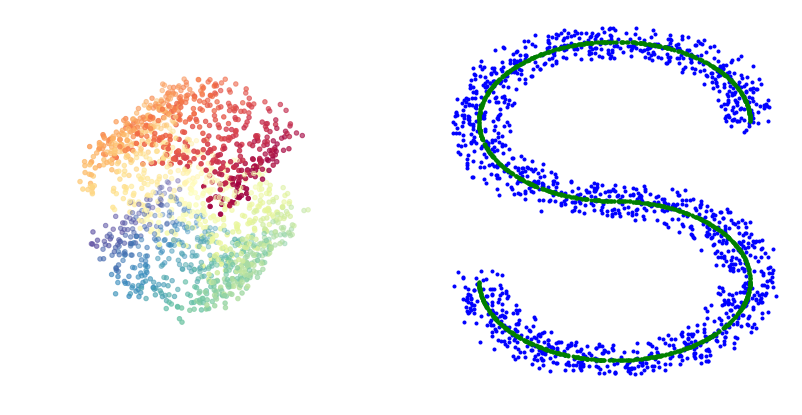

In [6]:
%matplotlib inline
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral, label='Noisy observations')
ax.axis('off')
ax = fig.add_subplot(122)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 2], 'g.', label='True manifold')
#ax.legend(loc=0)
ax.axis('off')
plt.savefig('original_s-shape.png', dpi=300)
plt.show()
plt.close()

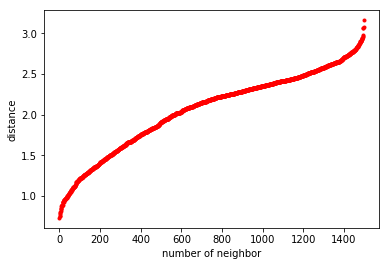

In [7]:
% matplotlib inline

# Fix a point and look at the distance to the closest neighbors

Y0 = Y[0]
dist = np.linalg.norm(Y - Y0, axis=1)
dist_sorted = np.sort(dist)

plt.figure()
plt.plot(np.arange(Y.shape[0]-1), dist_sorted[1:], 'r.')
plt.xlabel('number of neighbor')
plt.ylabel('distance')
plt.savefig('distances_s-shape.png', dpi=300)
plt.show()
plt.close()

#### Application of SAME to the S-shape dataset

In [8]:
# Choose the initial bandwidth as the distance to (alpha * n)-th neighbor of X0
alpha = 0.1
h0 = dist_sorted[int(alpha * n_samples)]
print(h0)

# parameters of SAME
n_iterations = 14
a = 1.25
bandwidths = h0 * np.sqrt(a**(-np.arange(n_iterations)))
print(bandwidths)
projectors = [np.identity(D)] * n_samples

1.3087829559910258
[1.30878296 1.17061106 1.04702636 0.93648885 0.83762109 0.74919108
 0.67009687 0.59935286 0.5360775  0.47948229 0.428862   0.38358583
 0.3430896  0.30686867]


In [9]:
X, projectors = SAME(Y, projectors, bandwidths, d=2, tau=h0)
# compare with the true values
print('Average squared error:', np.linalg.norm(X - Z, ord='fro')**2 / n_samples)        

Average squared error: 0.03930296177911789


#### Application of MBMS to the S-shape dataset

In [10]:
# parameters of MBMS
n_iterations = 2
bandwidth = 0.45
n_neighbors = 300

In [11]:
X_MBMS = MBMS(Y, bandwidth, n_iterations, n_neighbors, d=2)
# compare with the true values
print('Average squared error:', np.linalg.norm(X_MBMS - Z, ord='fro')**2 / n_samples)

Average squared error: 0.04757852332545408


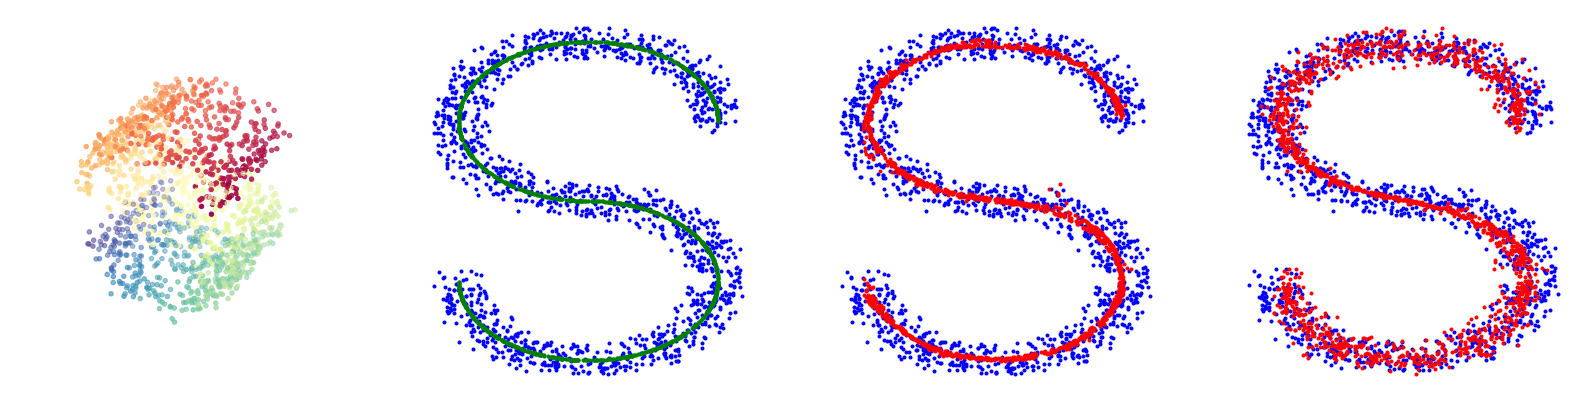

In [12]:
%matplotlib inline
fig = plt.figure(figsize=(28, 7))
ax = fig.add_subplot(141, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral, label='Noisy observations')
ax.axis('off')
ax = fig.add_subplot(142)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 2], 'g.', label='True manifold')
ax.axis('off')
ax = fig.add_subplot(143)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(X[:, 0], X[:, 2], 'r.', label='Recovered manifold')
ax.axis('off')
ax = fig.add_subplot(144)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(X_MBMS[:, 0], X_MBMS[:, 2], 'r.', label='Recovered manifold')
ax.axis('off')
plt.savefig('same_s-shape.png', dpi=300)
plt.show()
plt.close()

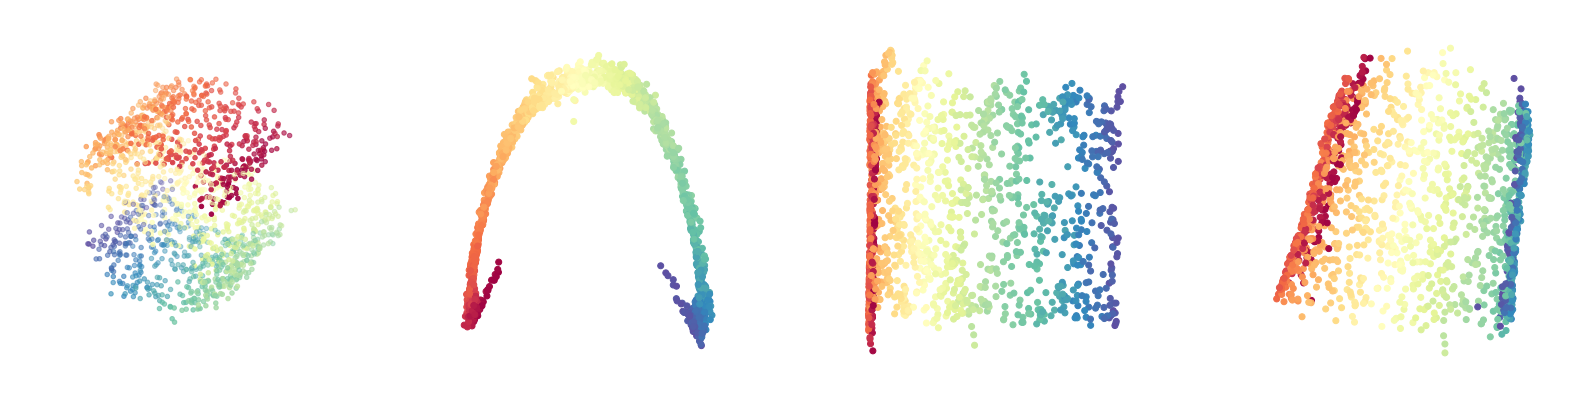

In [13]:
lle = LocallyLinearEmbedding(n_neighbors=120, n_components=2, method='modified')

U = lle.fit_transform(X)
T = lle.fit_transform(X_MBMS)
V = lle.fit_transform(Y)

%matplotlib inline

fig = plt.figure(figsize=(28, 7))
ax = fig.add_subplot(141, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral)
ax.axis('off')
ax = fig.add_subplot(142)
ax.scatter(V[:, 0], V[:, 1], c=t, cmap=plt.cm.Spectral)
ax.axis('off')
ax = fig.add_subplot(143)
ax.scatter(U[:, 0], U[:, 1], c=t, cmap=plt.cm.Spectral)
ax.axis('off')
ax = fig.add_subplot(144)
ax.scatter(T[:, 0], T[:, 1], c=t, cmap=plt.cm.Spectral)
ax.axis('off')
plt.savefig('dim_red_s-shape.png', dpi=300)
plt.show()

### Swiss roll

In [14]:
n_samples = 2500
noise_level = 1.5

# Ambient dimension
D = 20

# True values
Z, t = make_swiss_roll(n_samples, 0, random_state=1)
Z = np.append(Z, np.zeros((n_samples, D-3)), axis=1)

# Noisy Swiss Roll
eps = rand(n_samples, D) - 0.5
Y = Z + noise_level * eps

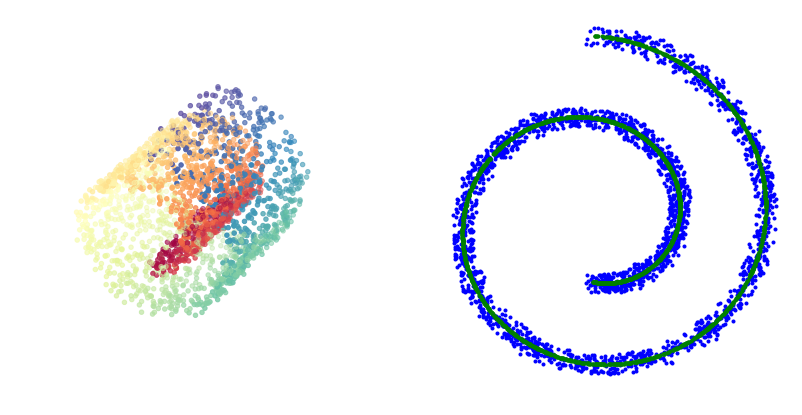

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral, label='Noisy observations')
ax.axis('off')
ax = fig.add_subplot(122)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 2], 'g.', label='True manifold')
#ax.legend(loc=0)
ax.axis('off')
plt.savefig('original_swiss_roll.png', dpi=300)
plt.show()
plt.close()

2.0817515559672173


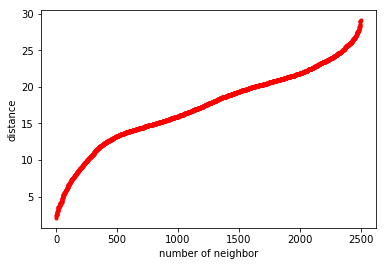

In [16]:
% matplotlib inline

# Fix a point and look at the distance to the closest neighbors

Y0 = Y[0]
dist = np.linalg.norm(Y - Y0, axis=1)
dist_sorted = np.sort(dist)
print(dist_sorted[1])

plt.figure()
plt.plot(np.arange(Y.shape[0]-1), dist_sorted[1:], 'r.')
plt.xlabel('number of neighbor')
plt.ylabel('distance')
plt.savefig('distances_swiss_roll.png', dpi=300)
plt.show()
plt.close()

#### Application of SAME to the Swiss Roll dataset

In [17]:
# Choose the initial bandwidth as the distance to (alpha * n)-th neighbor of X0
alpha = 0.015
h0 = dist_sorted[int(alpha * n_samples)]
print(h0)

n_iterations = 6
a = 1.25
bandwidths = h0 * np.sqrt(a**(-np.arange(n_iterations)))
print(bandwidths)
projectors = [np.identity(D)] * n_samples

4.078682827343983
[4.07868283 3.64808482 3.26294626 2.91846786 2.61035701 2.33477429]


In [18]:
X, projectors = SAME(Y, projectors, bandwidths, d=2, tau=h0)
# compare with the true values
print('Average squared error:', np.linalg.norm(X - Z, ord='fro')**2 / n_samples)

Average squared error: 0.6735288454470024


#### Application of MBMS to the Swiss Roll dataset

In [19]:
# parameters of MBMS
n_iterations = 1
bandwidth = 2.6
n_neighbors = 150

In [20]:
X_MBMS = MBMS(Y, bandwidth, n_iterations, n_neighbors, d=2)
# compare with the true values
print('Average squared error:', np.linalg.norm(X_MBMS - Z, ord='fro')**2 / n_samples)

Average squared error: 0.6927273720075748


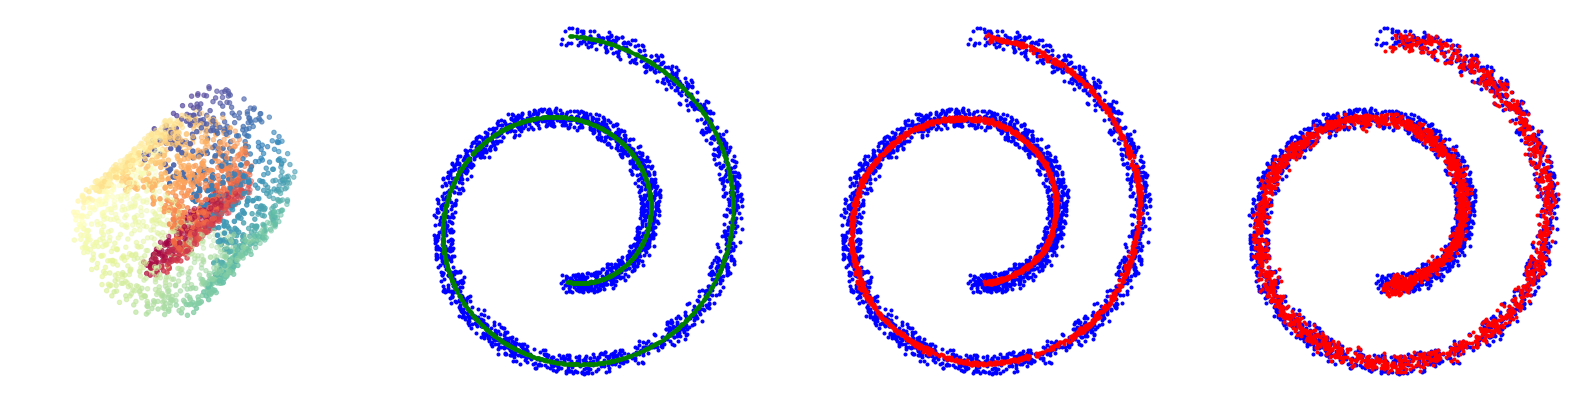

In [21]:
%matplotlib inline
fig = plt.figure(figsize=(28, 7))
ax = fig.add_subplot(141, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral, label='Noisy observations')
ax.axis('off')
ax = fig.add_subplot(142)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(Z[:, 0], Z[:, 2], 'g.', label='True manifold')
ax.axis('off')
ax = fig.add_subplot(143)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(X[:, 0], X[:, 2], 'r.', label='Recovered manifold')
ax.axis('off')
ax = fig.add_subplot(144)
ax.plot(Y[:, 0], Y[:, 2], 'b.', label='Noisy observations')
ax.plot(X_MBMS[:, 0], X_MBMS[:, 2], 'r.', label='Recovered manifold')
ax.axis('off')
plt.savefig('same_swiss_roll.png', dpi=300)
plt.show()
plt.close()

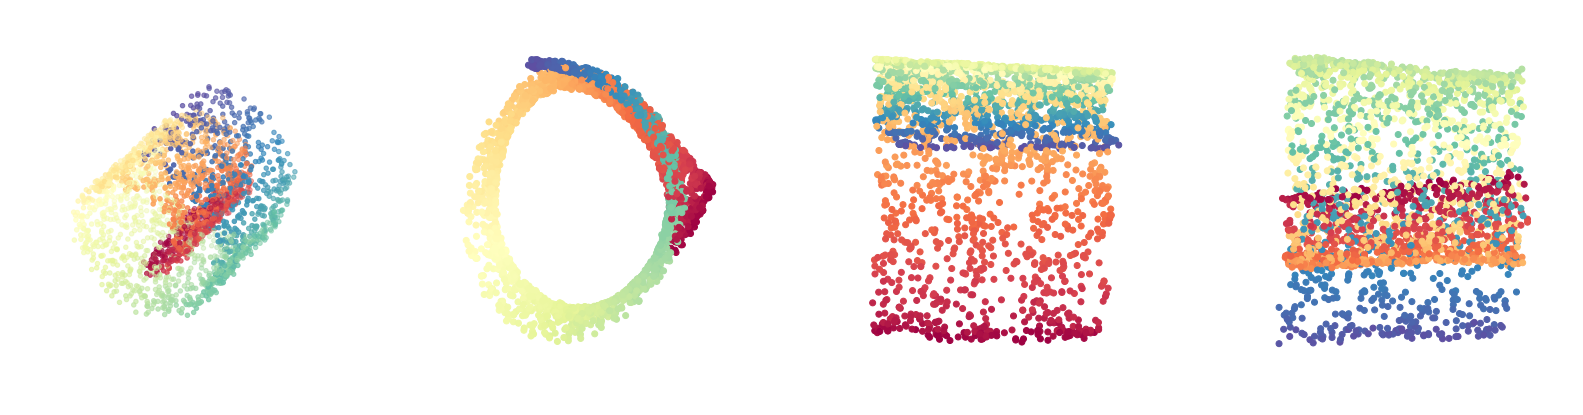

In [22]:
lle = LocallyLinearEmbedding(n_neighbors=70, n_components=2, method='modified')

U = lle.fit_transform(X)
T = lle.fit_transform(X_MBMS)
V = lle.fit_transform(Y)

%matplotlib inline

fig = plt.figure(figsize=(28, 7))
ax = fig.add_subplot(141, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=t, cmap=plt.cm.Spectral)
ax.axis('off')
ax = fig.add_subplot(142)
ax.scatter(V[:, 0], V[:, 1], c=t, cmap=plt.cm.Spectral)
ax.axis('off')
ax = fig.add_subplot(143)
ax.scatter(U[:, 0], U[:, 1], c=t, cmap=plt.cm.Spectral)
ax.axis('off')
ax = fig.add_subplot(144)
ax.scatter(T[:, 0], T[:, 1], c=t, cmap=plt.cm.Spectral)
ax.axis('off')
plt.savefig('dim_red_swiss_roll.png', dpi=300)
plt.show()